# Starfish-based analysis pipeline for 3nt data

## Imports and Experiment

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import scipy.ndimage as ndi
from skimage.filters import threshold_otsu
from starfish import Experiment, Codebook
from starfish.types import Axes, Levels
from starfish.image import ApplyTransform, LearnTransform, Filter
from starfish.spots import FindSpots, DecodeSpots
from starfish.morphology import Binarize, Merge, Segment #, Filter
import starfish.morphology # Filter is already imported from starfish.image
from tqdm import tqdm
from starfish.util.plot import diagnose_registration

from functions import get_rep_hpi_fov, common_roi
import pandas as pd


from scipy.ndimage import gaussian_filter
from starfish.core.intensity_table.intensity_table import IntensityTable
from skimage.filters import threshold_otsu, threshold_local, threshold_yen, threshold_triangle, threshold_sauvola, threshold_li, threshold_isodata, threshold_niblack
from skimage.restoration import rolling_ball
import xarray as xr
from starfish import ImageStack

In [3]:
filenames = os.listdir("manual_annotation_decoded")
filename = "rep1_hpi7_fov3.csv"
rep, hpi, fov_file = get_rep_hpi_fov(filename)
exp = Experiment.from_json(os.path.join(f"/tank/s391697/in-situ-seq-influenza/data/starfish/3nt/PR8/rep{rep}/{hpi}hpi", "experiment.json"))
fov = exp.fovs()[int(fov_file)]
imgs = fov.get_image("primary")
nuclei = fov.get_image("nuclei")
bf = fov.get_image("brightfield")

## Spot based registration

In [4]:
spots = imgs.reduce({Axes.CH}, func="max")
print(spots)
learn_translation = LearnTransform.Translation(reference_stack=spots.sel({Axes.ROUND: 0}), axes=Axes.ROUND, upsampling=1000)
warp = ApplyTransform.Warp()
transforms_list = learn_translation.run(spots)
registered_imgs = warp.run(imgs, transforms_list=transforms_list)
transforms_list = learn_translation.run(spots)
registered_nuclei = warp.run(nuclei, transforms_list=transforms_list)
transforms_list = learn_translation.run(spots)
registered_bf = warp.run(bf, transforms_list=transforms_list)
# re-create for saving as json
transforms_list = learn_translation.run(spots)

100%|██████████| 12/12 [00:00<00:00, 188.35it/s]


<starfish.ImageStack (r: 3, c: 1, z: 1, y: 2048, x: 2048)>


100%|██████████| 3/3 [00:00<00:00, 366.69it/s]


100%|██████████| 3/3 [00:00<00:00, 124.19it/s]


In [5]:
xroi, yroi = common_roi(transforms_list)
registered_imgs = registered_imgs.sel({Axes.X: xroi, Axes.Y: yroi})
registered_nuclei = registered_nuclei.sel({Axes.X: xroi, Axes.Y: yroi})
registered_bf = registered_bf.sel({Axes.X: xroi, Axes.Y: yroi})

### Inspect regestration: images

100%|██████████| 3/3 [00:00<00:00, 375.34it/s]

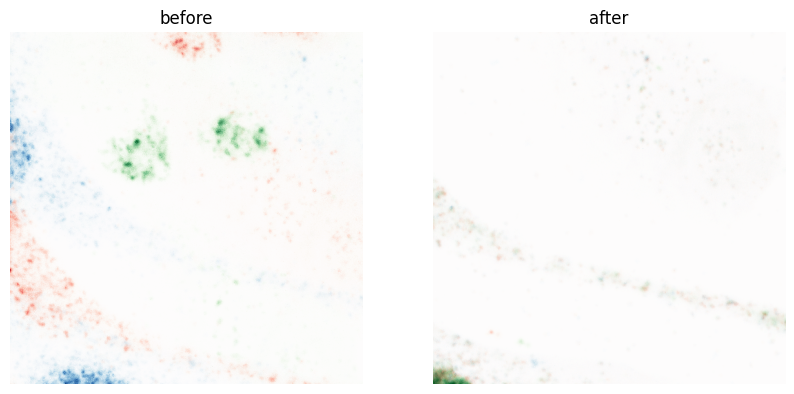

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
roi = slice(0,512)
diagnose_registration(imgs.reduce({Axes.CH}, "max").sel({Axes.X: roi, Axes.Y: roi}), {Axes.ROUND: 0}, {Axes.ROUND: 1}, {Axes.ROUND: 2}, ax=axs[0], title="before")
diagnose_registration(registered_imgs.reduce({Axes.CH}, "max").sel({Axes.X: roi, Axes.Y: roi}), {Axes.ROUND: 0}, {Axes.ROUND: 1}, {Axes.ROUND: 2}, ax=axs[1], title="after")

### Inspect registration nucleii

100%|██████████| 3/3 [00:00<00:00, 401.78it/s]


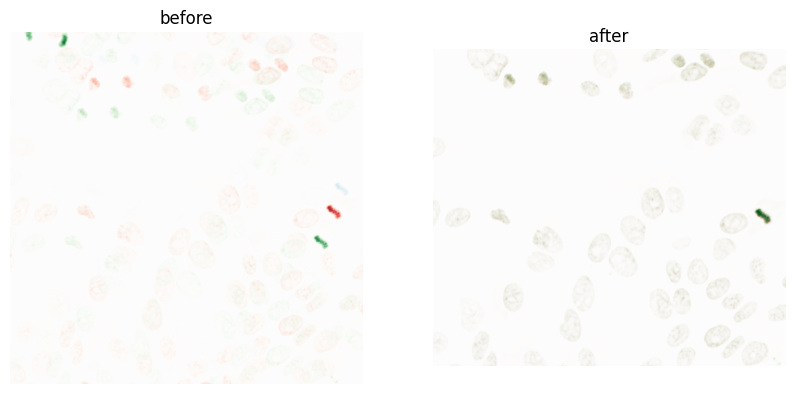

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
diagnose_registration(nuclei.reduce({Axes.CH}, "max"), {Axes.ROUND: 0}, {Axes.ROUND: 1}, {Axes.ROUND: 2}, ax=axs[0], title="before")
diagnose_registration(registered_nuclei.reduce({Axes.CH}, "max"), {Axes.ROUND: 0}, {Axes.ROUND: 1}, {Axes.ROUND: 2}, ax=axs[1], title="after")

## Background filtering

100%|██████████| 12/12 [00:00<00:00, 1648.06it/s]

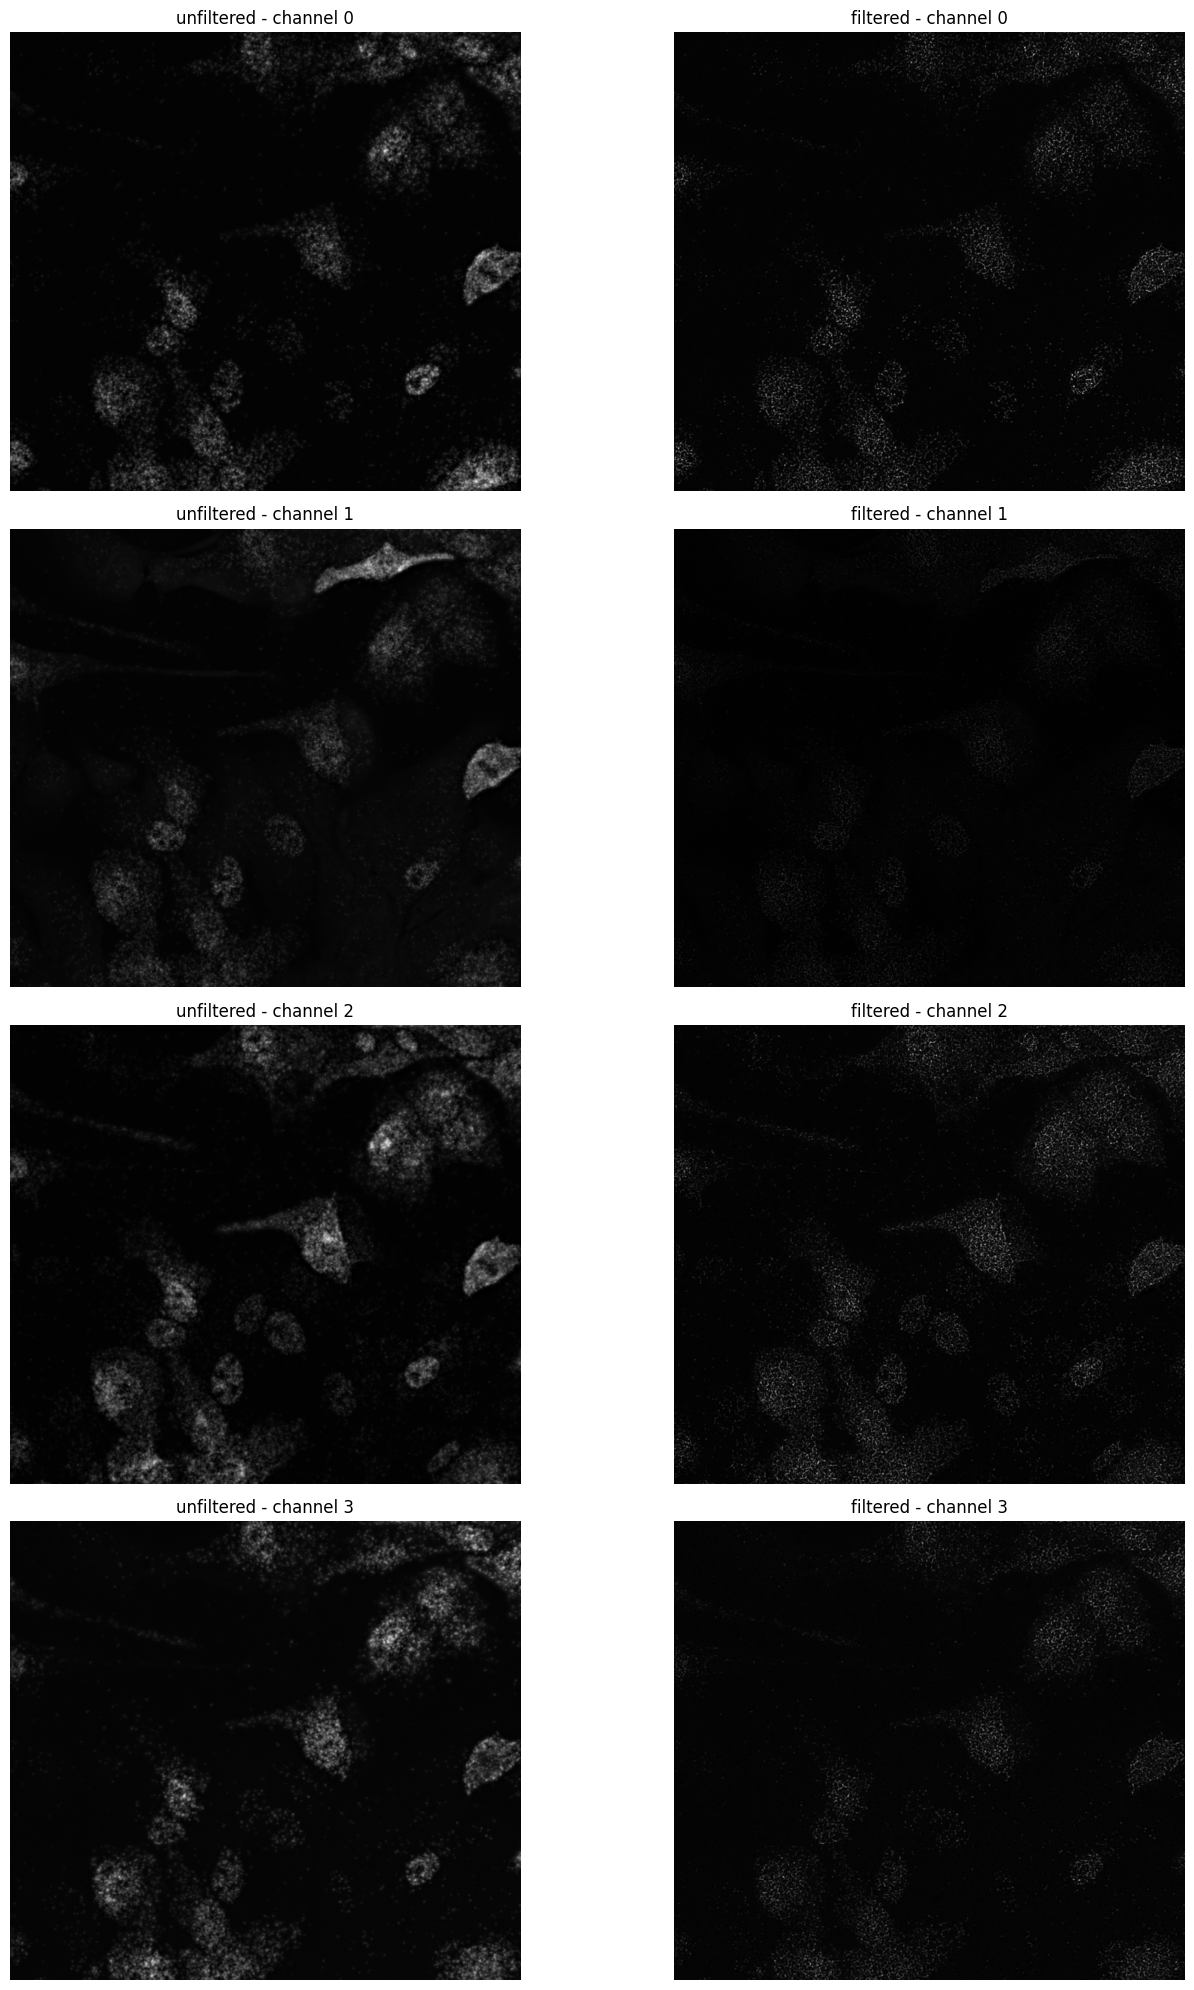

In [8]:
masking_radius = 4
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
filtered = filt.run(registered_imgs, verbose=True, in_place=False)
round = 0 
channels = len(filtered.xarray["c"])
vmin = imgs.xarray.min().values
vmax = imgs.xarray.max().values
plt.figure(figsize=(15, 20))

for ch in range(channels):
    plt.subplot(channels, 2, 2 * ch + 1)
    #plt.imshow(registered_imgs.xarray.sel({Axes.ROUND: round, Axes.CH: ch}).squeeze(), cmap='gray', vmax=vmax, vmin=vmin)
    plt.imshow(registered_imgs.xarray.sel({Axes.ROUND: round, Axes.CH: ch}).squeeze(), cmap='gray')
    plt.title(f"unfiltered - channel {ch}")
    plt.axis("off")

    plt.subplot(channels, 2, 2 * ch + 2)
    #plt.imshow(filtered.xarray.sel({Axes.ROUND: round, Axes.CH: ch}).squeeze(), cmap='gray', vmax=vmax, vmin=vmin)
    plt.imshow(filtered.xarray.sel({Axes.ROUND: round, Axes.CH: ch}).squeeze(), cmap='gray')
    plt.title(f"filtered - channel {ch}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Normalization

In [9]:
from starfish.util.plot import intensity_histogram

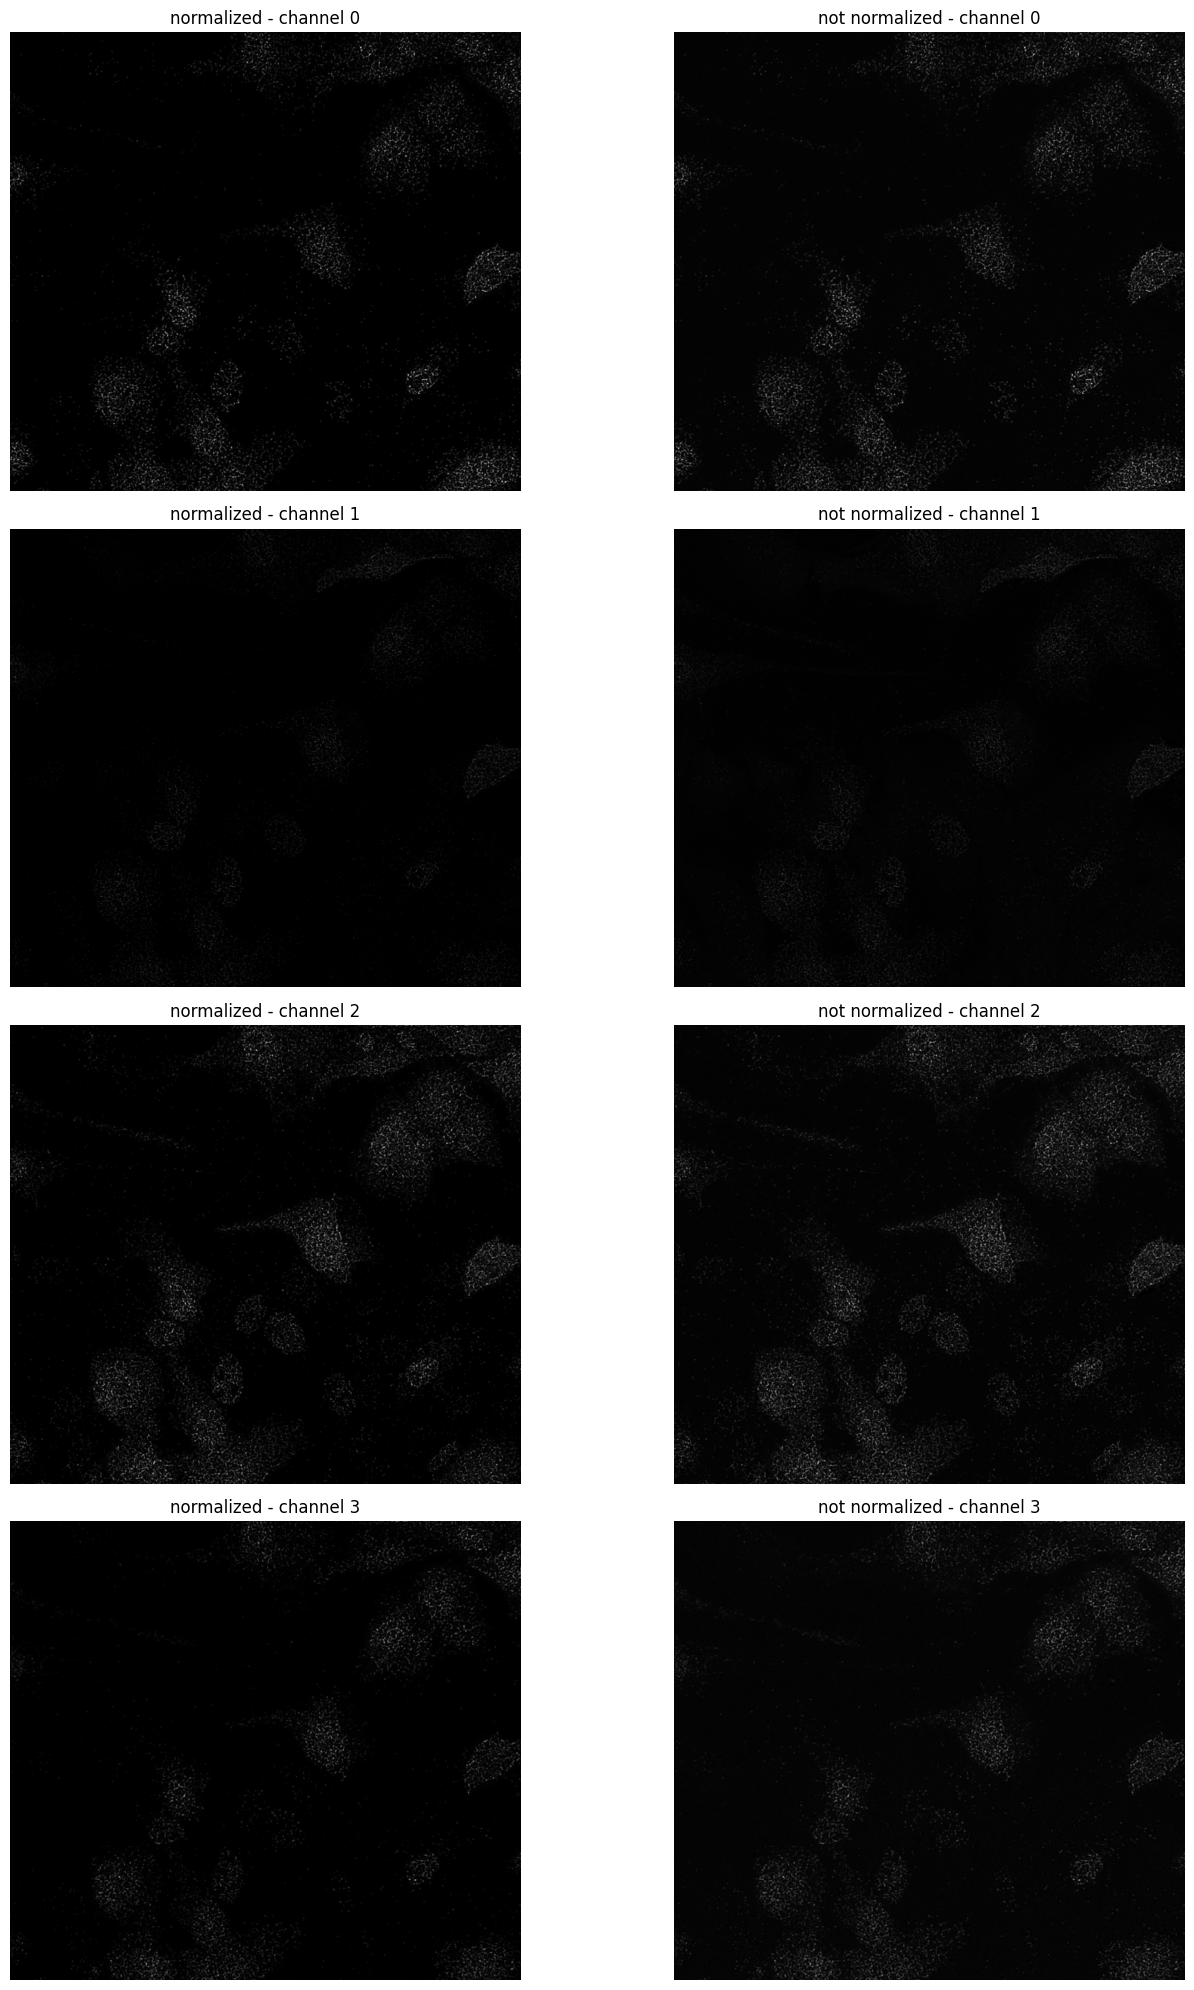

In [10]:
#cptz= Filter.ClipPercentileToZero(p_min=80, p_max=99.999, level_method=Levels.SCALE_BY_CHUNK)
cptz= Filter.ClipPercentileToZero(p_min=80, p_max=100, group_by={Axes.CH}, level_method=Levels.SCALE_BY_CHUNK)
clipped_both_scaled = cptz.run(filtered, in_place=False)
round = 0 
channels = len(filtered.xarray["c"])
plt.figure(figsize=(15, 20))

for ch in range(channels):
    plt.subplot(channels, 2, 2 * ch + 1)
    plt.imshow(clipped_both_scaled.xarray.sel({Axes.ROUND: round, Axes.CH: ch}).squeeze(), cmap='gray')
    plt.title(f"normalized - channel {ch}")
    plt.axis("off")

    plt.subplot(channels, 2, 2 * ch + 2)
    plt.imshow(filtered.xarray.sel({Axes.ROUND: round, Axes.CH: ch}).squeeze(), cmap='gray')
    plt.title(f"not normalized - channel {ch}")
    plt.axis("off")

plt.tight_layout()
plt.show()

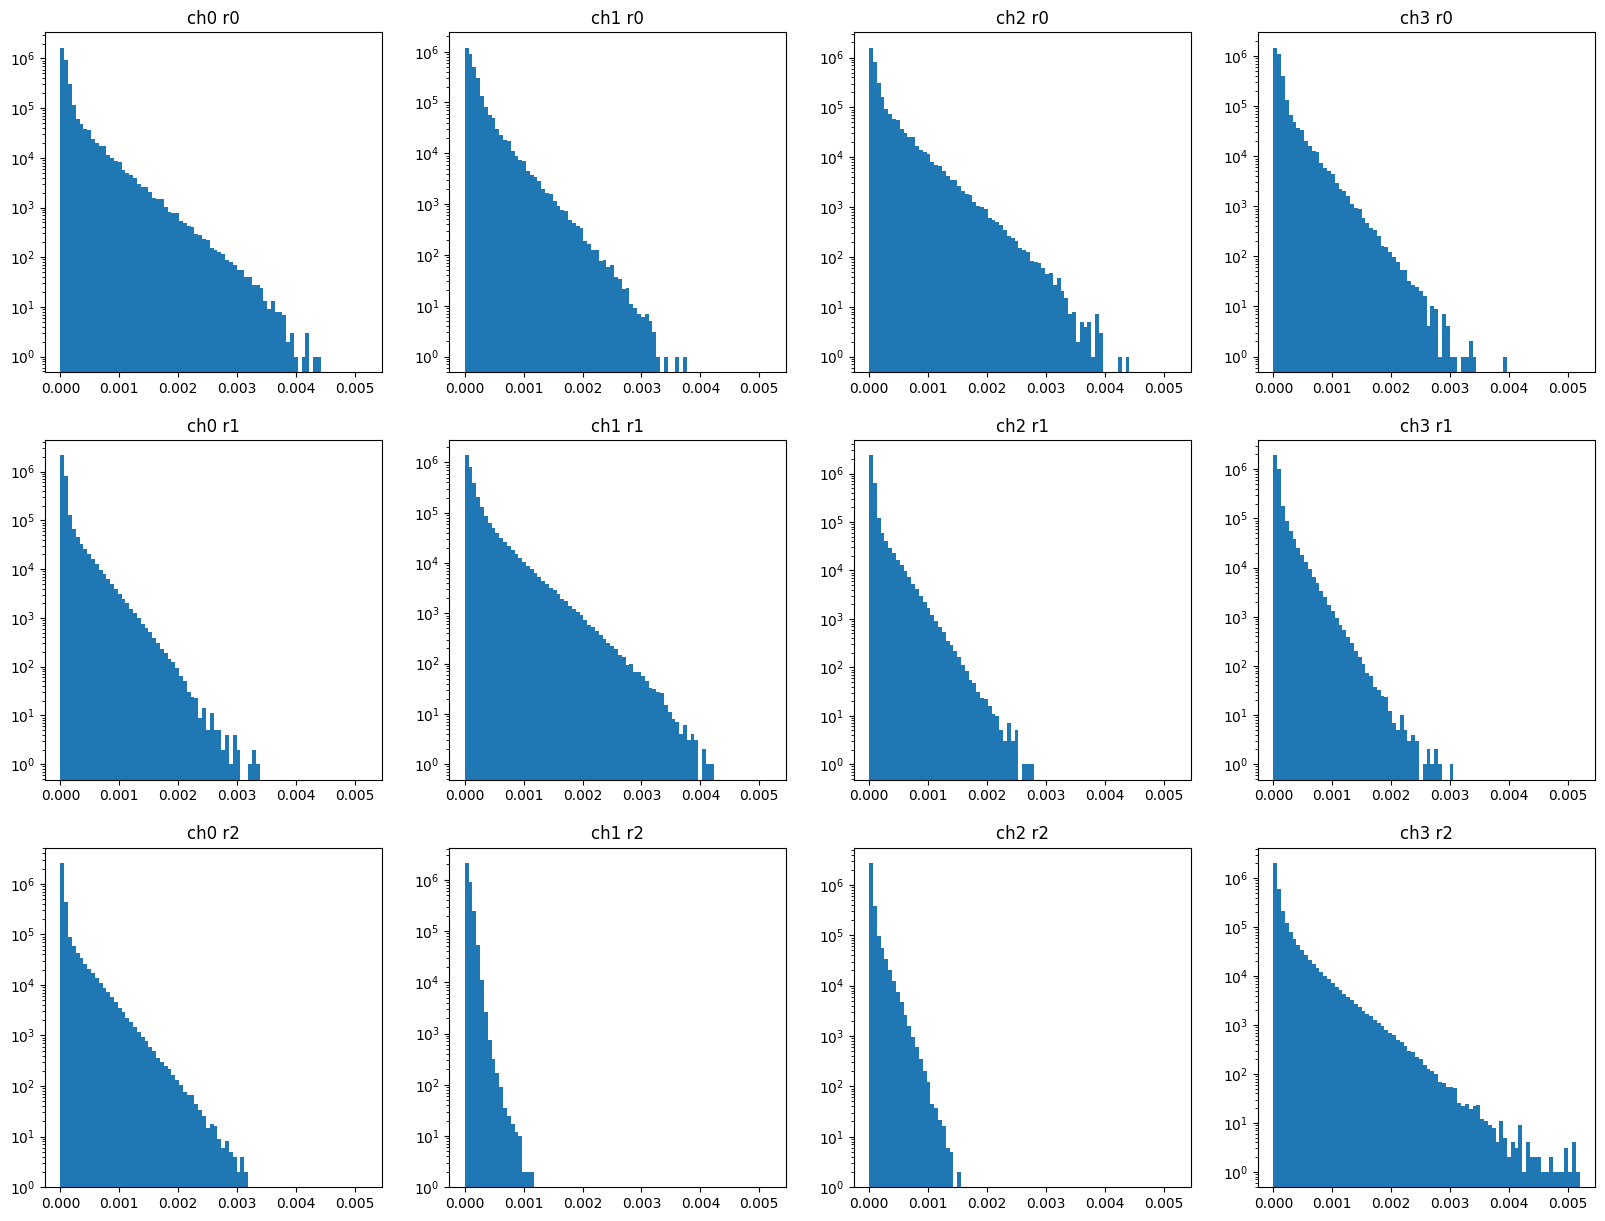

In [11]:
fig, axs = plt.subplots(3,4, figsize=(20,15))
for r in range(3):
    for c in range(4):
        intensity_histogram(filtered, sel={Axes.CH: c, Axes.ROUND: r}, bins=80, log=True, ax=axs[r,c], range=(0,.0052), title=f"ch{c} r{r}")

## Mask crowded and uncrowded spot regions

### Variance

In [12]:
from skimage.morphology import disk
from skimage.filters import rank

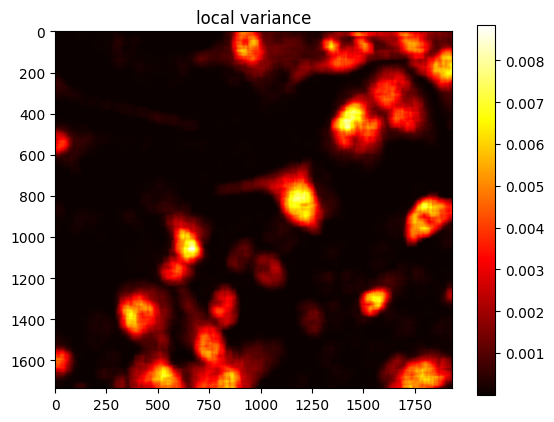

In [13]:
radius = 50
mean = ndi.uniform_filter(clipped_both_scaled.xarray.values, size=radius)
mean_of_square = ndi.uniform_filter(clipped_both_scaled.xarray.values**2, size=radius)
variance = mean_of_square - mean**2


plt.imshow(variance[0,0,0], cmap="hot")
plt.title("local variance")
plt.colorbar()

Text(0.5, 1.0, 'Variance filtered image')

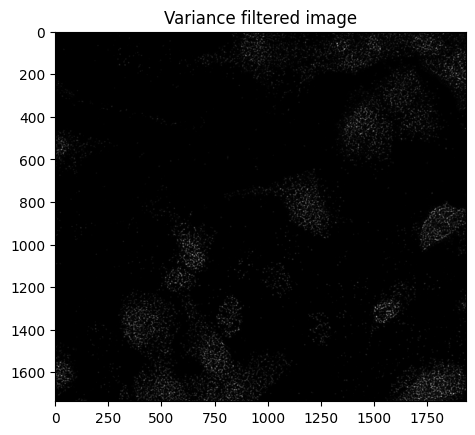

In [14]:
var_threshold = np.percentile(variance, 1)
high_var_mask = variance > var_threshold

var_filtered_image = np.where(high_var_mask, clipped_both_scaled.xarray.values, 0)
#clipped_both_scaled.xarray.values = var_filtered_image

plt.imshow(var_filtered_image[0,0,0], cmap="gray")
plt.title("Variance filtered image")

### continous regions

In [15]:
from skimage.morphology import closing, disk
from skimage.measure import label, regionprops

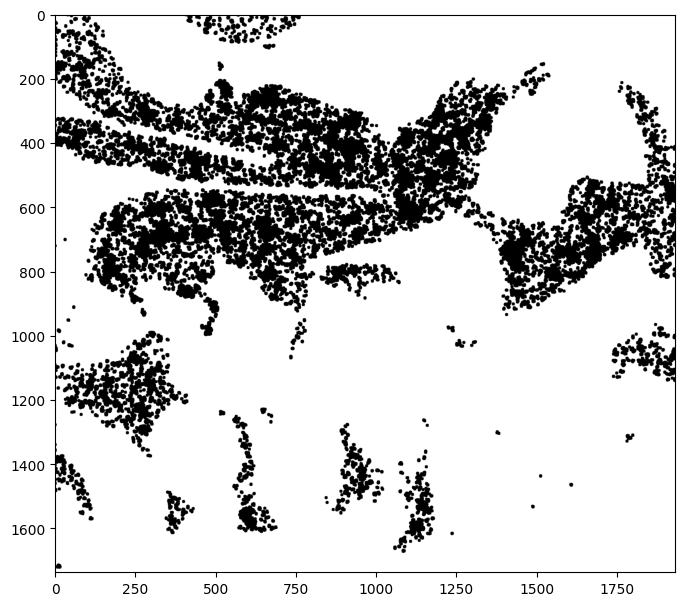

In [16]:
binary_image = clipped_both_scaled.xarray.sel({Axes.ROUND: 0, Axes.CH: 1}).squeeze() > np.percentile(clipped_both_scaled.xarray.values, 5)
closed = closing(binary_image, disk(5))
label_image = label(closed)

min_size = 200
large_regions = np.zeros_like(label_image)

for region in regionprops(label_image):
    if region.area > min_size:
        large_regions[label_image == region.label] = 1

plt.figure(figsize=(8,8))
plt.imshow(large_regions, cmap="gray")


### Gaussian filter

In [17]:
from scipy.ndimage import gaussian_filter
from starfish.core.intensity_table.intensity_table import IntensityTable
from skimage.filters import threshold_otsu, threshold_local, threshold_yen, threshold_triangle, threshold_sauvola, threshold_li, threshold_isodata, threshold_niblack
from skimage.restoration import rolling_ball
import xarray as xr
from starfish import ImageStack

In [18]:
import sys; print(sys.version)
import platform; print(platform.platform())
import skimage; print(f'scikit-image version: {skimage.__version__}')
import numpy; print(f'numpy version: {numpy.__version__}')

3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
Linux-6.8.0-79-generic-x86_64-with-glibc2.39
scikit-image version: 0.24.0
numpy version: 1.26.4


#### Maximum intensities

In [19]:
max_ints = []

for file in sorted(filenames):
    rep, hpi, fov_idx = get_rep_hpi_fov(file)
    primary_ds = xr.open_dataset(f"pipeline_output/final_pipe/3nt/PR8/rep{rep}/{hpi}hpi/fov_{fov_idx}_primary.nc")
    primary = primary_ds[list(primary_ds.data_vars)[0]]
    summed_img = primary.sum(dim=("r", "c"))
    img_2d = summed_img.values.squeeze()
    density_map = gaussian_filter(img_2d, sigma=5)
    max_ints.append(np.max(density_map))

pd.DataFrame({"file": sorted(filenames), "max_intensity": max_ints}).to_csv("data/max_intensities.csv", index=False)

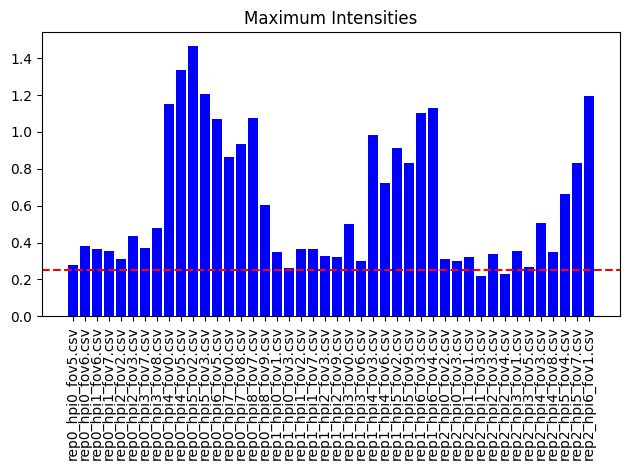

In [20]:
max_intensities = pd.read_csv("data/max_intensities.csv")
x = np.arange(len(max_intensities))

fig, ax = plt.subplots()
ax.bar(x, max_intensities.max_intensity, width=0.8, label="manuelle Annotation", color="blue")
ax.set_title("Maximum Intensities")
ax.set_xticks(x)
ax.set_xticklabels(max_intensities.file, rotation=90)
plt.axhline(y=0.25, color="red", linestyle="--")
plt.tight_layout()
plt.show()

#### Density map

In [21]:
pixel_intensities = IntensityTable.from_image_stack(clipped_both_scaled)
summed_img = clipped_both_scaled.xarray.sum(dim=("r", "c"))
img_2d = summed_img.values.squeeze()
density_map = gaussian_filter(img_2d, sigma=5)

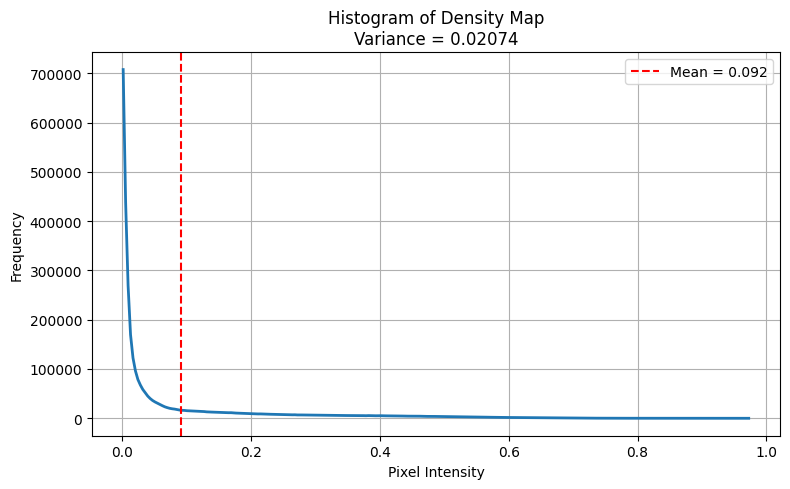

In [22]:
hist, bin_edges = np.histogram(density_map, bins=256)
variance = np.var(density_map)
mean = np.mean(density_map)

plt.figure(figsize=(8, 5))
plt.plot(bin_edges[:-1], hist, lw=2)

plt.axvline(mean, color='r', linestyle='--', label=f'Mean = {mean:.3f}')
plt.title(f"Histogram of Density Map\nVariance = {variance:.5f}")
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Regression model
Model predicts percentiles in intensity distribution to mask crowded and uncrowded spot regions

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import xarray as xr
from scipy.stats import skew, kurtosis, entropy
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

In [24]:
df = pd.read_csv("data/image_features.csv") ## -> from image_features.py

train_df = df[~df['manual_percentile'].isna()]
predict_df = df[df['manual_percentile'].isna()]

# prepare training data
y_train = train_df['manual_percentile'].values
X_train = train_df.drop(columns=['file', 'manual_percentile']).values

# define and train model
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# model validation on training data
y_pred_train = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_train))
print("Training R2:", r2_score(y_train, y_pred_train))

# model prediction
if not predict_df.empty:
    X_predict = predict_df.drop(columns=['file', 'manual_percentile']).values
    predicted_percentiles = model.predict(X_predict)
    predict_df['predicted_percentile'] = predicted_percentiles

train_df['predicted_percentile'] = train_df['manual_percentile']

result_df = pd.concat([train_df, predict_df])

result_df.to_csv("data/image_features_with_predictions.csv", index=False)

Training MAE: 1.936908032871324
Training R2: 0.9622584167257895


/tmp/ipykernel_2695205/1443402780.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['predicted_percentile'] = predicted_percentiles
/tmp/ipykernel_2695205/1443402780.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['predicted_percentile'] = train_df['manual_percentile']


#### Mask filtering

In [25]:
from scipy import ndimage

In [26]:
img_features = pd.read_csv("data/image_features_with_predictions.csv")  

density_map = np.load(f"pipeline_output/masks_threshold_model/3nt/PR8/rep{rep}/{hpi}hpi/fov_{fov_file}_density_map.npy") ## -> from masks.py
percentile = img_features[img_features["file"] == f"rep{rep}_hpi{hpi}_fov{fov_file}"].predicted_percentile.values[0]

if int(hpi) <= 3:
    percentile = 100

if percentile > 100:
    percentile = 100

print(f"file: rep{rep}_hpi{hpi}_fov{fov_file}, ", f"predicted percentile: {percentile}")

threshold_percentile = np.percentile(density_map, percentile)
mask_percentile = (density_map > threshold_percentile).astype(int)

file: rep2_hpi6_fov3,  predicted percentile: 92.65624599197456


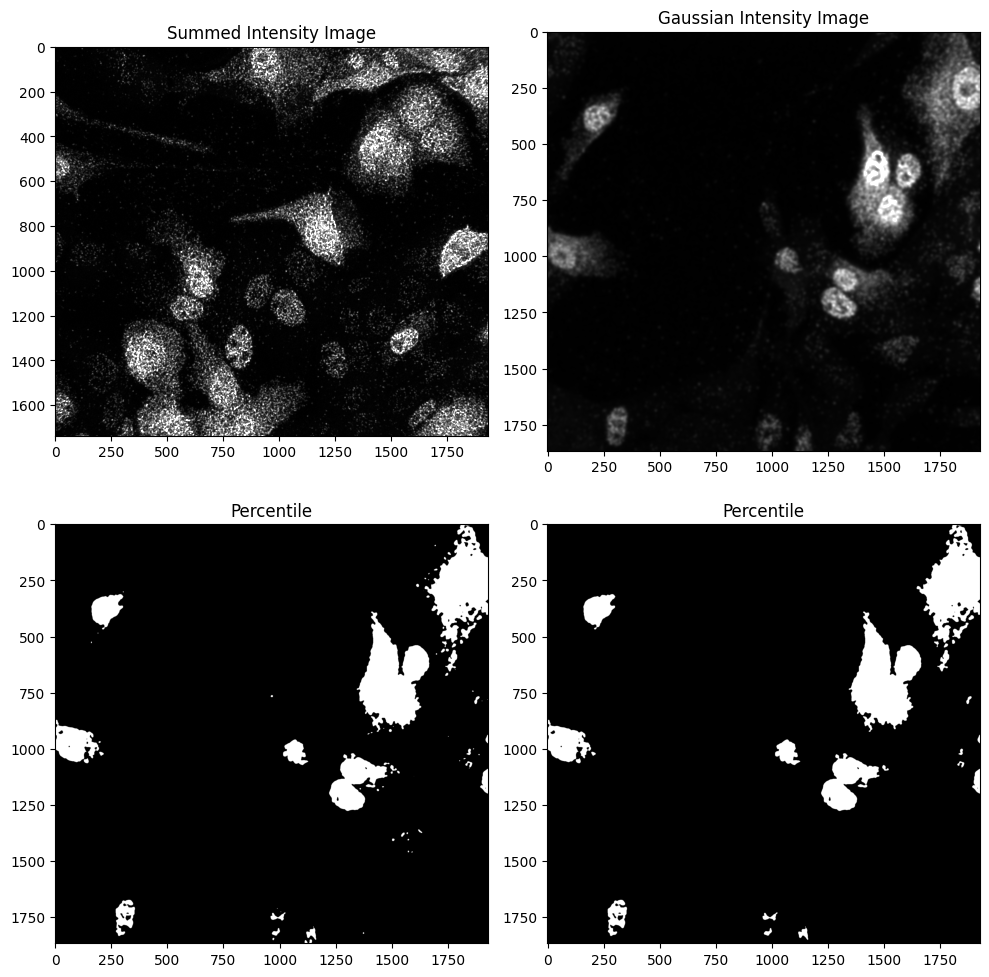

In [27]:
labeled_mask, num_features = ndimage.label(mask_percentile)
sizes = ndimage.sum(mask_percentile, labeled_mask, range(1, num_features + 1))

min_size = 200
mask_filtered = np.zeros_like(mask_percentile, dtype=bool)

for i, size in enumerate(sizes):
    if size >= min_size:
        mask_filtered[labeled_mask == (i + 1)] = True

n_rows = 2
n_cols = 2
plt.figure(figsize=(10, 10))
plt.subplot(n_rows, n_cols, 1)
plt.title("Summed Intensity Image")
plt.imshow(img_2d, cmap="gray", vmax=0.8)

plt.subplot(n_rows, n_cols, 2)
plt.title("Gaussian Intensity Image")
plt.imshow(density_map, cmap="gray", vmax=0.8)

plt.subplot(n_rows, n_cols, 3)
plt.title("Percentile")
plt.imshow(mask_percentile, cmap='gray')

plt.subplot(n_rows, n_cols, 4)
plt.title("Percentile")
plt.imshow(mask_filtered, cmap='gray')

plt.tight_layout()
plt.show()

## Spot detection

In [28]:
dots = clipped_both_scaled.reduce([Axes.CH, Axes.ROUND], "max")
bd = FindSpots.BlobDetector(
    min_sigma=1,
    max_sigma=5,
    num_sigma=20,
    threshold=.05,
    is_volume=True,
    measurement_type='max',
)
spots = bd.run(clipped_both_scaled, reference_image=dots)

100%|██████████| 1/1 [00:00<00:00, 330.49it/s]


## Spot-based decoding

In [29]:
single_codebook = Codebook.open_json('codebook_single_segment.json')

multi_barcode_decoder = DecodeSpots.MultiBarcodeDecoder(
    codebook=single_codebook,
    max_distance=.5,
    min_intensity=.1,
    return_original_intensities=True
)
mbd_decoded_spots = multi_barcode_decoder.run(spots=spots)
df_sbd = mbd_decoded_spots.to_features_dataframe()
df_sbd

intensity  z     y     x  radius  spot_id  z_min  z_max  y_min  y_max  \
0       0.520290  0    47   964     4.0        0      0      1     44     51   
1       0.987087  0    58  1325     4.0        1      0      1     55     62   
2       0.854328  0  1612  1899     4.0        2      0      1   1609   1616   
3       0.968598  0  1702  1872     4.0        3      0      1   1699   1706   
4       0.940383  0  1050   646     3.0        4      0      1   1048   1053   
...          ... ..   ...   ...     ...      ...    ...    ...    ...    ...   
11555   0.254815  0  1496   793     2.0    11555      0      1   1495   1498   
11556   0.010713  0  1027   939     2.0    11556      0      1   1026   1029   
11557   0.347940  0  1306  1526     2.0    11557      0      1   1305   1308   
11558   0.007183  0   983  1157     2.0    11558      0      1    982    985   
11559   0.229408  0   712  1153     2.0    11559      0      1    711    714   

       x_min  x_max  features        xc        yc        zc            target  \
0        961    968         0  0.025201  0.045956  0.001124     PB2,PB1,NP,NA   
1       1322   1329         1  0.025238  0.045957  0.001124      PB2(invalid)   
2       1896   1903         2  0.025298  0.046117  0.001124      PB2(invalid)   
3       1869   1876         3  0.025295  0.046126  0.001124    PB2,HA,NP,M,NS   
4        644    649         4  0.025168  0.046059  0.001124      PB2(invalid)   
...      ...    ...       ...       ...       ...       ...               ...   
11555    792    795     11555  0.025184  0.046105  0.001124      PB2,PB1,NP,M   
11556    938    941     11556  0.025199  0.046057  0.001124       NA(invalid)   
11557   1525   1528     11557  0.025259  0.046086  0.001124  PB2,PB1,HA,NP,NA   
11558   1156   1159     11558  0.025221  0.046052  0.001124           missing   
11559   1152   1155     11559  0.025221  0.046024  0.001124            PB2,NS   

       passes_thresholds  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True  
...                  ...  
11555               True  
11556               True  
11557               True  
11558               True  
11559               True  

[11560 rows x 18 columns]

## Pixel-based decoding

### Decoding 

**Magnitude threshold**  
Only strong signals, magnitude_threshold = 0.3 – 0.5 ✅  
Normal sensitivity	0.2 – 0.3  
Detection of weak spots	0.1 – 0.2 ⚠️  
Risk to detect noise is high < 0.1 🔴  
  
**Distance_threshold**  
Only really certain matches	0.15 – 0.25 ✅  
Tolerance for weaker signals	0.3 – 0.35 🟡  
Lot of false positives	> 0.4 🔴 

**PROBLEM:** The PBD depends on the pixel intensity (magnitude_threshold). Since the intensities vary irregularly between the reps, hpis, and fovs, the PBD is not equally effective everywhere. The parameters would need to be adapted adaptively, for example by linking them to the density.

In [30]:
from starfish.core.spots.DetectPixels.pixel_spot_decoder import MultiBarcodePixelSpotDecoder
import pandas as pd
from sklearn.cluster import DBSCAN
from starfish.core.intensity_table.intensity_table import IntensityTable
import xarray as xr
from starfish.core.imagestack.imagestack import ImageStack
from functions import iterative_pbd

#### Decoding and Clustering

In [31]:
distance_thresh = 0.25
magnitude_thresh = 0.3
single_codebook = Codebook.open_json('codebook_single_segment.json')

decoder = MultiBarcodePixelSpotDecoder(
    codebook=single_codebook,
    metric="cosine",
    norm_order=2,
    distance_threshold=distance_thresh,
    magnitude_threshold=magnitude_thresh,
)
decoded_pixels = decoder.run(clipped_both_scaled)
decoded_pixels

<xarray.DecodedIntensityTable (features: 66639, r: 3, c: 4)>
array([[[3.01246315e-01, 2.85247136e-02, 0.00000000e+00, 0.00000000e+00],
        [1.62704866e-02, 1.19563065e-01, 1.85480155e-02, 0.00000000e+00],
        [3.73444892e-02, 0.00000000e+00, 0.00000000e+00, 1.21278912e-01]],

       [[2.88136117e-02, 4.37126756e-02, 4.18070287e-01, 3.91536392e-02],
        [0.00000000e+00, 9.64138284e-03, 1.81170762e-01, 5.97425562e-04],
        [1.92937232e-03, 0.00000000e+00, 0.00000000e+00, 4.83889394e-02]],

       [[2.40337700e-01, 6.54045194e-02, 0.00000000e+00, 0.00000000e+00],
        [8.03614408e-02, 6.95809796e-02, 3.41989333e-03, 0.00000000e+00],
        [3.01873224e-04, 0.00000000e+00, 0.00000000e+00, 1.80109262e-01]],

       ...,

       [[0.00000000e+00, 0.00000000e+00, 2.87182182e-01, 0.00000000e+00],
        [3.89448702e-02, 3.25174816e-02, 5.58074517e-03, 2.65414529e-02],
        [7.40733743e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 2.26819143e-01, 1.78587958e-02],
        [0.00000000e+00, 8.64839032e-02, 0.00000000e+00, 0.00000000e+00],
        [1.91318616e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 7.82075222e-05, 2.79946953e-01, 1.51852379e-02],
        [2.97677740e-02, 3.30668576e-02, 0.00000000e+00, 7.53619447e-02],
        [1.44795269e-01, 0.00000000e+00, 0.00000000e+00, 4.04407876e-03]]],
      dtype=float32)
Coordinates:
  * features           (features) int64 0 1 2 3 4 ... 66635 66636 66637 66638
  * r                  (r) int64 0 1 2
  * c                  (c) int64 0 1 2 3
    x                  (features) int64 900 904 913 914 ... 1860 1875 1886 1914
    y                  (features) int64 0 0 0 0 0 0 ... 1736 1736 1736 1736 1736
    z                  (features) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    target             (features) <U3 'PB2' 'NA' 'PB2' 'PB2' ... 'M' 'M' 'M'
    distance           (features) float32 0.106 0.1923 0.1302 ... 0.05895 0.1929
    passes_thresholds  (features) bool True True True True ... True True True

In [32]:
df_pixel = decoded_pixels.to_features_dataframe()  

eps_dist = 1
min_pixels = 3

coords = df_pixel[["x", "y"]].to_numpy()
clustering = DBSCAN(eps=eps_dist, min_samples=min_pixels).fit(coords)
df_pixel["spot_id"] = clustering.labels_
df_pixel = df_pixel[df_pixel["spot_id"] != -1]

spot_coords = df_pixel.groupby("spot_id")[["x", "y"]].mean().reset_index()
df_pixel = df_pixel.drop(columns=[col for col in df_pixel.columns if col in ["x_center", "y_center"]])
df_pixel = df_pixel.merge(spot_coords, on="spot_id", suffixes=("", "_center"))
df_pixel["distance_to_center"] = np.sqrt((df_pixel['x'] - df_pixel['x_center'])**2 + (df_pixel['y'] - df_pixel['y_center'])**2)
spot_radii = df_pixel.groupby("spot_id")["distance_to_center"].max().reset_index(name="radius")
spot_coords = spot_coords.merge(spot_radii, on="spot_id")

spot_targets = df_pixel.groupby("spot_id")["target"].unique().reset_index()
spot_targets['target'] = spot_targets['target'].apply(lambda x: ','.join(sorted(set(x))))

feature_df_pbd = spot_coords.merge(spot_targets[["spot_id", "target"]], on="spot_id")
feature_df_pbd.to_csv(f"pipeline_output/test_pbd/pbd_results.csv", index=False)

#### Iterative Decoding

In [33]:
ds = xr.open_dataset(f"pipeline_output/pipe_with_masks/3nt/PR8/rep1/5hpi/fov_8_primary.nc")
ds = ds.rename({"c": "ch", "r": "round"})
ds = ds.transpose("round", "ch", "z", "y", "x")

array = ds.to_array().values 

if array.shape[0] == 1 and len(array.shape) == 6:
    array = array[0]

assert array.ndim == 5, f"Array ist {array.ndim}D statt 5D: shape = {array.shape}"

image_stack = ImageStack.from_numpy(
    array,
    index_labels={
        Axes.ROUND: list(range(array.shape[0])),
        Axes.CH: list(range(array.shape[1])),
        Axes.ZPLANE: list(range(array.shape[2])),
    }
)

# iterative_pbd_df = iterative_pbd(image_stack, start_dist_thresh=0.25, dist_thresh_interval=0.1, start_mag_thresh=0.30, mag_thresh_interval=0.15, intervals=2)
iterative_pbd_df = iterative_pbd(image_stack, start_dist_thresh=0.25, dist_thresh_interval=0.05, start_mag_thresh=0.30, mag_thresh_interval=0.075, intervals=3)
#iterative_pbd_df = iterative_pbd(image_stack, start_dist_thresh=0.20, dist_thresh_interval=0.05, start_mag_thresh=0.4, mag_thresh_interval=0.075, intervals=3)

100%|██████████| 12/12 [00:00<00:00, 432.28it/s]


In [34]:
df_pixel = iterative_pbd_df  
eps_dist = 1
min_pixels = 3

coords = df_pixel[["x", "y"]].to_numpy()
clustering = DBSCAN(eps=eps_dist, min_samples=min_pixels).fit(coords)
df_pixel["spot_id"] = clustering.labels_
df_pixel = df_pixel[df_pixel["spot_id"] != -1]

spot_coords = df_pixel.groupby("spot_id")[["x", "y"]].mean().reset_index()
df_pixel = df_pixel.drop(columns=[col for col in df_pixel.columns if col in ["x_center", "y_center"]])
df_pixel = df_pixel.merge(spot_coords, on="spot_id", suffixes=("", "_center"))
df_pixel["distance_to_center"] = np.sqrt((df_pixel['x'] - df_pixel['x_center'])**2 + (df_pixel['y'] - df_pixel['y_center'])**2)
spot_radii = df_pixel.groupby("spot_id")["distance_to_center"].max().reset_index(name="radius")
spot_coords = spot_coords.merge(spot_radii, on="spot_id")

counts = df_pixel.groupby(["spot_id", "target"]).size().reset_index(name="count")
total_counts = df_pixel.groupby("spot_id").size().reset_index(name="total")
merged = counts.merge(total_counts, on="spot_id")
merged["fraction"] = merged["count"] / merged["total"]

filtered = merged[merged["fraction"] >= 0.1]

spot_targets = (
    filtered[["spot_id", "target"]]
    .groupby("spot_id")["target"]
    .apply(lambda x: ",".join(sorted(set(x))))
    .reset_index()
)

feature_df_pbd = spot_coords.merge(spot_targets[["spot_id", "target"]], on="spot_id")

feature_df_pbd["target"] = feature_df_pbd["target"].fillna("unassigned")

spot_iters = df_pixel.groupby("spot_id")["iter"].unique().reset_index()
spot_iters["iter"] = spot_iters["iter"].apply(lambda x: ",".join(map(str, sorted(set(x)))))

feature_df_pbd = feature_df_pbd.merge(spot_iters, on="spot_id")

feature_df_pbd.to_csv(f"pipeline_output/test_pbd/iterative_pbd_results.csv", index=False)

## Segmentation

In [35]:
# don't use starfish.image.Segment.Watershed because it uses hard coded thresholds for nucleus size (10,10000) which are not applicable here
# see: https://spacetx-starfish.readthedocs.io/en/latest/gallery/tutorials/watershed_segmentation.html

nuclei_red = registered_nuclei.reduce(dims=[Axes.ROUND, Axes.CH, Axes.ZPLANE], func="max")
smoothed_nuclei = Filter.GaussianLowPass(sigma=5, is_volume=False).run(nuclei_red)
dapi_thresh = threshold_otsu(smoothed_nuclei.xarray.values) # e.g. .048, binary mask for cell (nuclear) locations
stain_thresh = 0.004  # binary mask for overall cells // binarization of stain
min_dist = 56
min_allowed_size = 1000
max_allowed_size = 100000

binarized_nuclei = Binarize.ThresholdBinarize(dapi_thresh).run(smoothed_nuclei)
labeled_masks = starfish.morphology.Filter.MinDistanceLabel(min_dist, 1).run(binarized_nuclei)
watershed_markers = starfish.morphology.Filter.AreaFilter(min_area=min_allowed_size, max_area=max_allowed_size).run(labeled_masks)

thresholded_stain = Binarize.ThresholdBinarize(stain_thresh).run(nuclei_red)
markers_and_stain = Merge.SimpleMerge().run([thresholded_stain, watershed_markers])
watershed_mask = starfish.morphology.Filter.Reduce(
    "logical_or",
    lambda shape: np.zeros(shape=shape, dtype=bool)
).run(markers_and_stain)

segmenter = Segment.WatershedSegment(connectivity=np.ones((1, 3, 3), dtype=bool))

# masks is BinaryMaskCollection for downstream steps
masks = segmenter.run(
    nuclei_red,
    watershed_markers,
    watershed_mask,
)

100%|██████████| 1/1 [00:00<00:00, 398.66it/s]


100%|██████████| 1/1 [00:00<00:00, 455.90it/s]
